<a href="https://colab.research.google.com/github/IntroComputationalPhysics-UNT/kapitza-pendulum-JeremyKvale/blob/main/Kapitza_Pendulum_Jeremy_Kvale.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kapitza Pendulum
### Purpose:
The purpose of this notebook is to simulate and explore the Kapitza Pendulum; a.k.a. a pendulum whose pivot point is driven vertically so that its equilibrium is opposite of a normal pendulum (pendulum bob above the pivot point as opposed to below it). The goal is to find a combination of variables so that this is satisfied and to simulate the pendulum's movement over a long time scale.

## Background/Introduction:
The equation of motion for a vertically-driven pendulum with damping is described as:
$\ddot{\theta} + 2\gamma\dot{\theta} + [\omega_0^2 - \frac{y_0}{l}\omega_d^2cos(\omega_d t)]sin(\theta)$

In this equation, $\gamma$ is the damping coefficient, $\omega_0$ is the natural frequency (equivalent to $\sqrt{\frac{g}{l}}$), $y_0$ is the amplitude of the pivot point's movement, $l$ is the length of the pendulum, $\omega_d$ is the driving frequency of the pivot point, $t$ is the time, and $\theta$ is the angle (along with its time derivative, $\dot{\theta}$ and $\ddot{\theta}$).

This equation contains a lot of terms, so it would be easier to simplify the equation and attempt to make all of the terms dimensionless.

If we instead measure time in terms of the driving frequency, we get $\tau = \omega_d t$ and $d\tau = \omega_d dt$.

Now we can replace all of our time derivatives with this new $\tau$ term:
$\omega_d^2\frac{d^2\theta}{d\tau^2} + 2\omega_d\gamma\frac{d\theta}{d\tau} + [\omega_0^2 - \frac{y_0}{l}\omega_d^2cos(\tau)]sin(\theta)$

This equation can be simplified much further by simply diving both sides by $\omega_d^2$:

$\frac{d^2\theta}{d\tau^2} + \frac{2\gamma}{\omega_d}\frac{d\theta}{d\tau} + [\frac{\omega_0^2}{\omega_d^2} - \frac{y_0}{l}cos(\tau)]sin(\theta)$

We can simplify further by letting $\zeta = \frac{\gamma}{\omega_d}$, $\epsilon = \frac{\omega_0}{\omega_d}$, and $\alpha = \frac{y_0}{l}$:

$\theta'' + 2\zeta\theta' + [\epsilon^2 - \alpha cos(\tau)]sin(\theta)$

($\theta'$ and $\theta''$ are the time derivatives of $\theta$ **with respect to $\tau$**)

This is the equation of motion we will be using and solving.

## Pseudocode:
**1. Import Packages/Modules**
  - `numpy` as `np`
  - `solve_ivp` from `scipy.integrate`
  - `matplotlib.pyplot` as `plt`

**2. Define Equation of Motion**
  - Define our function `kapitza_pendulum(tau, y, epsilon, alpha, zeta)`
  - `tau` is the time in terms of omega_d (dimensionless)
  - `y` is the state variable of the function
  - `epsilon` is the frequency ratio (dimensionless)
  - `alpha` is the deflection/displacement relative to the length of the pendulum (dimensionless)
  - `zeta` is the rescaled damping coefficient (dimensionless)

**3. Define Utilities for Stability Diagnostics**
  - `basic_plot(t, y, xlabel=None, ylabel=None, figsize=(3,3))` gives a basic formatted plot

**4. Solve Equation of Motion**
  - Define initial conditions `y_0=[theta_0, ang_vel_0]` where theta_0 = pi and ang_vel_0 = 0
  - We know that the epsilon value has to be between 0 and 1 (greater than 1 would mean that the pendulum is naturally swinging faster than the driving frequency, preventing any form of stability, and we want a high driving frequency so that there is a sufficient restoring force to keep it inverted)
  - We know that the alpha value has to be between 0 and 1 (greater than 1 would mean that pivot point is oscillating a larger distance the pendulum's length, resulting in chaos since we want a high driving frequency: the pivot point is being driven fast, so if it has a massive amplitude, then it would cause the pendulum to not be stable almost at all)

**5. Analyze Long-Time Behavior vs. Parameters**
  - Predict the boundary line between stable and unstable (to be plotted in section 6)
  - Find some relationship between $\epsilon$ and $\alpha$ that yields a stable point/curve at $\theta = \pi$
  - `is_stable(theta_trajectory, threshold=0.1, check_fraction=0.8)` does a sweep across inputs and sees if the behavior stays within a certain threshold for a given portion of the simulation with a certain combination of inputs

**6. Plot**
  - Use the `basic_plot` function to plot the pendulum's angle with respect to time ($\tau$)
  - Our goal with this graph is to have a straight line on our desired angle ($\pi$), but we will likely have some function that oscillates around it then slowly approaches the angle over time
  - Create a plot with $\epsilon$ on the x-axis and $\alpha$ on the y-axis with the prediction boundary between stable and unstable

**7. Stability Analysis and Conclusion**
  - Write/describe a function of the boundary line between stable and unstable from the plot section (alpha vs. epsilon graph)
  - Compare the numerical function to the predicted boundary


## **1. Import Modules**

In [174]:
import numpy as np # Allows numerical meshes and sheets of data
from scipy.integrate import solve_ivp # Imports a differential equation solver
import matplotlib.pyplot as plt # Used for graphing and plotting
import matplotlib.animation as animation # For animation
from matplotlib.animation import FuncAnimation # For animation
from IPython.display import HTML # For animation

## **2. Define Equation of Motion**

In [175]:
# Define equation of motion function:
def pivot_driven_pendulum(tau, y, epsilon, alpha, zeta):
  """
  This function outputs the time derivatives, theta' and theta'' with respect to the tau
  Tau is the time in terms of omega_d (dimensionless)
  Y is the state variable of the function
  Epsilon is the frequency ratio (dimensionless)
  Alpha is the deflection/displacement relative to the length of the pendulum (dimensionless)
  Zeta is the rescaled damping coefficient (dimensionless)
  """
  theta, ang_vel = y
  dtheta_dtau = ang_vel
  d2theta_dtau2 = -2*zeta*dtheta_dtau - (epsilon**2 - alpha*np.cos(tau))*np.sin(theta)
  dy_dtau = np.array([dtheta_dtau, d2theta_dtau2])
  return dy_dtau

## **3. Define Utilities for Stability Diagnostics**

In [176]:
# Basic formatted plot

def basic_plot(t, y, xlabel=None, ylabel=None, figsize=(3,3)): # Gives us a basic formatted plot
  plt.figure(figsize=figsize)
  plt.plot(t, y)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  return plt.show()

## **4. Solve Equation of Motion**

In [177]:
# Parameters and Initial Conditions:
epsilon = 0.2 # Ideally less than 1
alpha = 0.5 # Ideally less than 1
zeta = 0.1 # Ideally pretty small

# Number of Decay Times:
n_decay = 25 # This is how many cycles of decay for the pendulum (how many cycles of 1/2*zeta)


# Time Span:
tau_min = 0
tau_max = n_decay/(2*zeta) # Decay rate after solving the differential equation (theta'' + 2*zeta*theta' = 0)
tau_span = [tau_min, tau_max]

# Initial State:
delta_theta = 0.01 # Deviation of theta from pi; small value
theta_0 = np.pi - delta_theta # Initial angle; we want it near the inverted state, but not so biased toward it that we don't get any meaningful information
ang_vel_0 = 0 # A nonzero initial angular velocity would make stability more difficult
y_0 = [theta_0, ang_vel_0] # Initial state variables

In [178]:
# Solve the Equation of Motion:
solution = solve_ivp(pivot_driven_pendulum,
                    tau_span, y_0, # Defines the initial conditions and the time span for the function
                    args=(epsilon, alpha, zeta), # Input variables
                    method='Radau', # Method for solving the differential equation
                    dense_output=True)

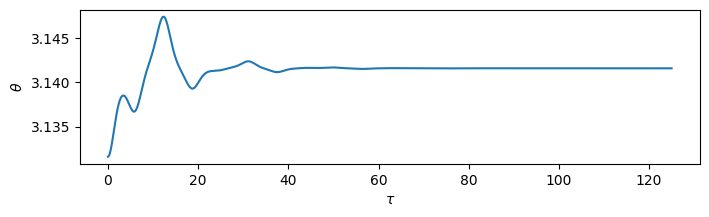

In [179]:
# Plot Theta
tau_plot = np.linspace(tau_min, tau_max, 1000) # Number of points
theta_plot = solution.sol(tau_plot)[0]

plt.figure(figsize=(8,2))
plt.plot(tau_plot, theta_plot)
plt.xlabel(r'$\tau$')
plt.ylabel(r'$\theta$')
plt.show()

## **5. Analyze Long-Term Behavior vs. Parameters**

In [180]:
# Stability Checker Function

def is_stable(theta_trajectory, threshold=0.1, check_fraction=0.8):
  """
  This function checks if the angle is within a certain threshold of pi
  `theta_trajectory` is a numpy array containing all angles of theta in the simulation
  `threshold` is the maximum allowed deviation from pi to be considered stable; I chose 0.1 radians (~5.7 degrees)
  `check_fraction` is the portion of the simulation we are checking; I chose 0.8, which means we check the last 80% of the simulation; the first part of the simulation would be too unstable and chaotic to derive meaningful results from

  It returns a true or false value depending on if the pendulum is stable or not
  """
  if len(theta_trajectory) == 0: # This is just a check to make sure there are angles in `theta_trajectory`; more of a formality
    return False


  # Calculate the start index for checking stability
  start_index = int(len(theta_trajectory) * (1 - check_fraction))
  # This removes the first part of the simulation; discards any portion not defined by the `check_fraction`


  # Extract the relevant portion of the trajectory to check
  check_trajectory = theta_trajectory[start_index:]
  # This rescales the simulation so that we only consider everything past the `start_index`


  # Check if all values in check_trajectory are within the threshold of np.pi
  is_within_threshold = np.abs(check_trajectory - np.pi) < threshold
  # This finds the deviation of each angle in `check_trajectory` from pi, takes the absolute value of it, and compares it to the allowed threshold for stability
  # If this deviation is greater than the threshold, then the function will return `false`


  return np.all(is_within_threshold)

In [181]:
# Printing the Result

stability_result = is_stable(theta_plot)

# Print the result
print(f"Is the pendulum stable? {stability_result}")

Is the pendulum stable? True


In [182]:
# Over a Grid of Inputs:

# Parameters
n_points = 10 # Number of points for epsilon and alpha
epsilon_list = np.linspace(0.01, 1, n_points) # Epsilon values from just above 0 up to 1
alpha_list = np.linspace(0.01, 1, n_points) # Alpha values from just above 0 up to 1
zeta = 0.1 # Fixed zeta value

In [183]:
# Determining Stability

stability_results = [] # Empty list to be appended

# Loop through each combination of epsilon and alpha
for epsilon in epsilon_list:
  for alpha in alpha_list:
    tau_span = [tau_min, tau_max] # Same time (tau) span as previously defined; `tau_max` is defined by the decay rate (defined by zeta)
    y_0 = [theta_0, ang_vel_0] # Same initial conditions as earlier


    solution = solve_ivp(pivot_driven_pendulum, # Solving the equation of motion, but now for each epsilon input and alpha input
                        tau_span,
                        y_0,
                        args=(epsilon, alpha, zeta),
                        method='Radau')


    theta_trajectory = solution.y[0] # Extracts the theta trajectory solutions
    stable = is_stable(theta_trajectory) # Checks if each theta is stable
    stability_results.append((epsilon, alpha, stable)) # Appends the list of stable combinations if stable

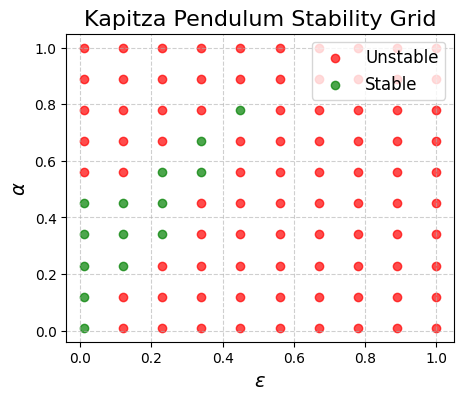

In [184]:
# Stability and Instability Combination Lists

stable_epsilons = [] # Creates a list of stable epsilon values
stable_alphas = [] # Creates a list of stable alpha values
unstable_epsilons = [] # Creates a list of unstable epsilon values
unstable_alphas = [] # Creates a list of unstable alpha values


for epsilon, alpha, stable_status in stability_results:
  if stable_status: # Any combination of epsilon and alpha that is stable is put here
    stable_epsilons.append(epsilon)
    stable_alphas.append(alpha)
  else: # Any combination of epsilon and alpha that is unstable is put here
    unstable_epsilons.append(epsilon)
    unstable_alphas.append(alpha)


plt.figure(figsize=(5, 4))
plt.scatter(unstable_epsilons, unstable_alphas, color='red', label='Unstable', alpha=0.7) # Unstable points are red
plt.scatter(stable_epsilons, stable_alphas, color='green', label='Stable', alpha=0.7) # Stable points are green
plt.xlabel(r'$\epsilon$', fontsize=14)
plt.ylabel(r'$\alpha$', fontsize=14)
plt.title('Kapitza Pendulum Stability Grid', fontsize=16)
plt.legend(fontsize=12) # Adds a legend
plt.grid(True, linestyle='--', alpha=0.6) # Formatting for the grid
plt.show() # One thing to notice is that I did this after the contour graph, and these two graphs have a very similar pattern/shape for stability, but this one is much less detailed

## **6. Plot**

In [185]:
# Estimating the Stability Line

# Before making the contour plot, my estimate for the stable relationship between epsilon and alpha is linear (alpha = 2*epsilon)
# Not all points above that line are stable, and I am guessing that any point above the curve alpha = epsilon^2 + .5 is unstable (they meet at epsilon = 1 and alpha = 1.5); just going based off of the grid

In [186]:
# Contour Plot Parameters

# Redefining Initial Conditions
delta_theta = 0.01 # Some very small angular deviation from pi
theta_0 = np.pi - delta_theta # Initial angle
ang_vel_0 = 0 # Initial angular velocity
y_0 = [theta_0, ang_vel_0] # Initial state variable

# Time Averaging Function
def average_long_timescale_response(epsilon, alpha, zeta, n_decay=100, delta_theta=0.01):
  """
  This function calculates the long timescale response of the inverted pendulum.
  """
  # Time span for the solve_ivp
  tau_min = 0
  tau_max = n_decay / (2 * zeta) # Decay rate after solving the differential equation (theta'' + 2*zeta*theta' = 0)
  tau_span = [tau_min, tau_max]

  # Solve the equation of motion for the given parameters
  solution = solve_ivp(pivot_driven_pendulum,
                      tau_span, y_0,
                      args=(epsilon, alpha, zeta),
                      method='Radau',
                      dense_output=True)

  tau_averaging_range = np.linspace((n_decay - 1)/(2 * zeta), (n_decay)/(2 * zeta), 1000)
  cos_theta_averaging = np.mean(np.cos(solution.sol(tau_averaging_range)[0])) # Takes the average of the cosine of theta over the simulation

  return cos_theta_averaging, solution

In [187]:
# Creating functions for averaging over a long timescale with decay taken into consideration

cos_theta_averaging, solution = average_long_timescale_response(epsilon, alpha, zeta, n_decay=n_decay)
tau_averaging_range = np.linspace((n_decay - 1)/(2 * zeta), (n_decay)/(2 * zeta), 1000)

In [188]:
# Creating a prediction function for the relationship between alpha and epsilon

def alpha_critical(epsilon, zeta, shift, coef):
  """
  This gives a function for alpha in terms of epsilon, zeta, and some coefficient
  We are holding zeta constant
  """
  alpha_linear = shift + coef*epsilon # Just a guess; unjustified completely; omits zeta
  return alpha_linear

# Creating a prediction function for a parabola based on epsilon

def alpha_parabolic(epsilon, a, b):
  """
  This function defines a parabolic boundary for alpha in terms of epsilon
  """
  alpha_parabolic = a + b * epsilon**2
  return alpha_parabolic

# Creating a prediction function for a sinusoidal shape based on epsilon

def alpha_sinusoidal(epsilon, c, d, e):
  """
  This function defines a sinusoidal boundary for alpha in terms of epsilon
  """
  alpha_sinusoidal = c + d * np.cos(e * epsilon)
  return alpha_sinusoidal

In [189]:
# Extracting long time scale response on mesh of epsilon and alpha and plot with contour plot
epsilon_list = np.linspace(0.01,0.7,10) # List of epsilon values to be used on the contour plot
alpha_list = np.linspace(0,1,10) # List of alpha values to be used on the contour plot
zeta = 0.1 # Zeta held constant

n_decay = 150

# Initialize our mesh for the average long time scale response
cos_theta_mesh = np.zeros((len(alpha_list), len(epsilon_list))) # Creates a blank mesh of zeros with columns equal to the amount of epsilons in epsilon_list and rows equal to the number of alphas in alpha_list

for i, alpha in enumerate(alpha_list):
  for j, epsilon in enumerate(epsilon_list):
    cos_theta_averaging, solution = average_long_timescale_response(epsilon, alpha, zeta, n_decay=n_decay)
    cos_theta_mesh[i,j] = cos_theta_averaging # Changes each element in the cos_theta_mesh based on the cos_theta_averaging function

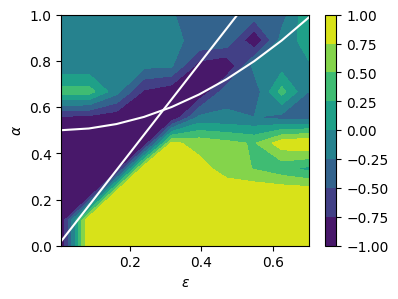

In [190]:
# Plotting the Contour Plot with Predictions

plt.figure(figsize=(4,3))
plt.contourf(epsilon_list, alpha_list, cos_theta_mesh)
plt.plot(epsilon_list, alpha_critical(epsilon_list, zeta, 0, 2), 'w') # White line is my initial prediction, alpha = 2 * epsilon
plt.plot(epsilon_list, alpha_parabolic(epsilon_list, 0.5, 1), 'w') # White parabola is my initial prediction for the upper boundary, alpha = epsilon^2 + 0.5
plt.xlabel(r'$\epsilon$')
plt.ylabel(r'$\alpha$')
plt.ylim(0,max(alpha_list))
plt.colorbar()
plt.show()

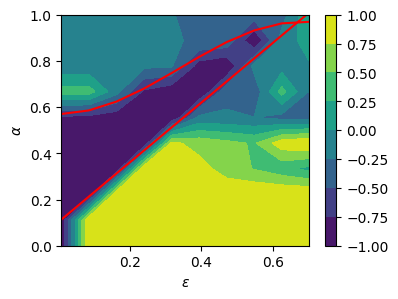

In [191]:
# Plotting the Contour Plot with More Accurate Values

plt.figure(figsize=(4,3))
plt.contourf(epsilon_list, alpha_list, cos_theta_mesh)
plt.plot(epsilon_list, alpha_critical(epsilon_list, zeta, 0.1, 1.3), 'r') # Red line is the more accurate line, alpha = 1.3 * epsilon + 0.1
plt.plot(epsilon_list, alpha_sinusoidal(epsilon_list, 0.77, -0.2, -4.6), 'r') # Red sinusoidal graph is the more accurate upper boundary, alpha = -0.2 * cos(-4.6 * epsilon) + 0.77
plt.xlabel(r'$\epsilon$')
plt.ylabel(r'$\alpha$')
plt.ylim(0,max(alpha_list))
plt.colorbar()
plt.show()

## **7. Stability Analysis and Conclusion**

My prediction for the stability boundaries were:

Lower boundary: $\alpha = 2\epsilon$

Upper boundary: $\alpha = \epsilon^2 + 0.5$

The more accurate boundaries were:

Lower boundary: $\alpha = 1.3\epsilon + 0.1$

Upper boundary: $\alpha = -0.2cos(-4.6\epsilon) + 0.77$

The problem with my predictions is that the area between my boundaries was indeed entirely stable, but it only included about a third of the total stable region.

The refined contour plot has the entire stable region (plus some not very stable combinations unfortunately; I was guesstimating the curves, and this was the closest I could get).